# DeepLearning homework
## **Team Deepsea**
## Members:
  - Márton Csáki (Neptun: R0OQD4)
  - Ogleznyev Pável (Neptun: GRKO04)
  - Marák Levente (Neptun: K2DE0K)

# Project
  The Airbus Ship Detection Challenge on Kaggle is a computer vision competition that tasks participants with developing models to automatically identify and localize ships in satellite imagery. The goal is to create an algorithm that can accurately draw bounding boxes or pixel-level masks around ships, thereby aiding maritime surveillance and efficiency. This project involves significant work in image segmentation and object detection using machine learning techniques.
  https://www.kaggle.com/competitions/airbus-ship-detection

## Key Aspects of the Project
  **Goal:** To automatically detect and localize ships in satellite images.

  **Data:** A large dataset of high-resolution satellite images provided by Airbus Defence and Space.

  **Task:** This is primarily an image segmentation challenge, where models must output masks that delineate the exact shape and location of each ship.

  **Application:** The resulting models have practical applications in maritime security, tracking, and logistics.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2  # OpenCV for image handling
import os
import matplotlib.pyplot as plt

# Mount Google Drive and set the data directory
Our data is too large to simply download from the copetition's site, so we uploaded it using Google Drive.

## 1. Step: Paths and Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_BASE_DIR = "/content/drive/MyDrive/DeepLearn/airbus-ship-detection"
TRAIN_IMG_DIR = os.path.join(DRIVE_BASE_DIR, "train_v2")
CSV_PATH = os.path.join(DRIVE_BASE_DIR, "train_ship_segmentations_v2.csv")

In [ ]:
# 768x768 is too large for initial training.
# Start with a smaller but still meaningful size. 224x224 is too small.
IMG_SIZE = (256, 256)
BATCH_SIZE = 16

## 2. Step: Load and Prepare Metadata (from CSV)

In [ ]:
print("Loading metadata and grouping by ImageId...")
df = pd.read_csv(CSV_PATH)

# A single image (ImageId) can have multiple ships (multiple rows).
# NaN means no ship present.
# Replace NaN with a placeholder 'NO_SHIP'
df['EncodedPixels'] = df['EncodedPixels'].fillna('NO_SHIP')

# Group by ImageId and collect all RLE masks for each image
metadata = df.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

# Create a 'has_ship' column for stratified splitting
# If the list contains only 'NO_SHIP', label as 0; otherwise, 1
def check_has_ship(rle_list):
    if len(rle_list) == 1 and rle_list[0] == 'NO_SHIP':
        return 0
    return 1

metadata['has_ship'] = metadata['EncodedPixels'].apply(check_has_ship)

# For images without ships, replace the RLE list with an empty list
metadata.loc[metadata['has_ship'] == 0, 'EncodedPixels'] = metadata.loc[metadata['has_ship'] == 0, 'ImageId'].apply(lambda x: [])

print(f"Total number of images (based on metadata): {len(metadata)}")
print(metadata.head())

Loading metadata and grouping by ImageId...
Total number of images (based on metadata): 192556
         ImageId                                      EncodedPixels  has_ship
0  00003e153.jpg                                                 []         0
1  0001124c7.jpg                                                 []         0
2  000155de5.jpg  [264661 17 265429 33 266197 33 266965 33 26773...         1
3  000194a2d.jpg  [360486 1 361252 4 362019 5 362785 8 363552 10...         1
4  0001b1832.jpg                                                 []         0


#Split


## 3. Step: Split Data (Train/Validation IDs)
# Split the metadata DataFrame, not the actual files

In [ ]:
print("Splitting data (80% train, 20% validation)...")
train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    random_state=42,
    stratify=metadata['has_ship']  # ensures both sets have ship/no-ship samples
)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Splitting data (80% train, 20% validation)...
Training samples: 154044, Validation samples: 38512


## 4. Step: Helper Functions (Mask Handling)
# Converts RLE-encoded strings into binary masks

In [ ]:
def rle_to_mask(rle_list, shape=(768, 768)):
    '''
    rle_list: A list of RLE strings for one image.
    shape: Original image size.
    '''
    master_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for rle_string in rle_list:
        if rle_string == 'NO_SHIP' or rle_string == '':
            continue

        s = rle_string.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1  # convert to 0-based indexing

        for lo, hi in zip(starts, starts + lengths):
            master_mask[lo:hi] = 1

    master_mask = master_mask.reshape(shape).T  # transpose required for RLE format
    master_mask = np.expand_dims(master_mask, axis=-1)
    return master_mask

## 5. Step: Main Data Pipeline (Generator)

In [ ]:
def data_generator(df):
    for _, row in df.iterrows():
        image_id = row['ImageId']
        rle_list = row['EncodedPixels']

        # 1. Load image
        img_path = os.path.join(TRAIN_IMG_DIR, image_id)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Missing image - {image_id}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # normalize

        # 2. Load mask
        mask = rle_to_mask(rle_list)
        mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)  # use NEAREST for masks
        mask = np.expand_dims(mask, axis=-1) if mask.ndim == 2 else mask

        yield img.astype(np.float32), mask.astype(np.float32)

## 6. Step: Create tf.data.Dataset

In [ ]:
print("Building TensorFlow data pipelines...")

# Training pipeline
train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)
    )
)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation pipeline (no shuffle)
val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)
    )
)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Datasets are ready for training (train_ds, val_ds).")

Building TensorFlow data pipelines...
Datasets are ready for training (train_ds, val_ds).


## 7. Step: Visualization (Verification)

Visualizing 5 random samples...


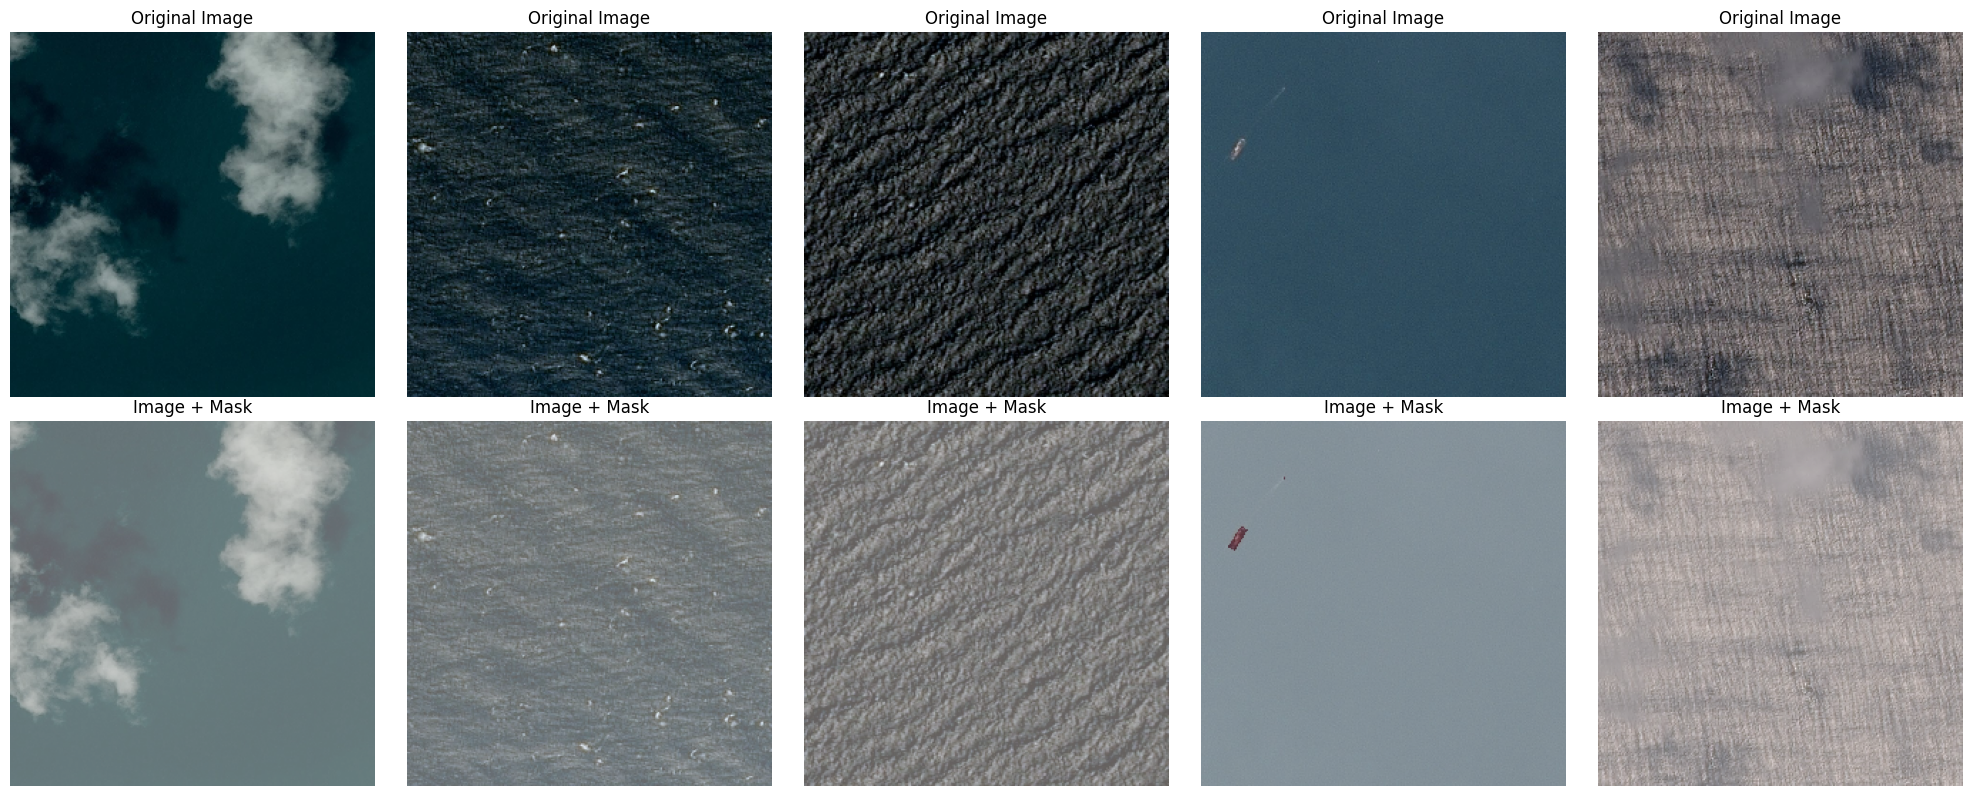

In [ ]:
print("Visualizing 5 random samples...")

images, masks = next(iter(train_ds))  # take one batch

plt.figure(figsize=(20, 8))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(images[i])
    plt.imshow(masks[i], alpha=0.4, cmap='Reds')
    plt.title("Image + Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()
